# Categorização de Compras

# Importa Bibliotecas

In [1]:
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from swat import *
# import dlpy
# from dlpy.timeseries import plot_timeseries
# from dlpy.splitting import two_way_split
# from dlpy import Sequential
# from dlpy.layers import * 
# from dlpy.model import Optimizer, AdamSolver, Sequence
import dlpy
from dlpy import *
from dlpy import Sequential
from dlpy.splitting import three_way_split
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextClassification
from dlpy.metrics import accuracy_score, roc_auc_score, confusion_matrix
%matplotlib inline

# Connect to SAS Viya

In [2]:
sas = CAS('localhost', 5570, 'sasdemo', getpass('Please enter your passwod:'))

Please enter your passwod:········


# Load Action Sets

In [3]:
sas.loadactionset('fedSql')
sas.loadactionset('sampling')
print('Done!')

NOTE: Added action set 'fedSql'.
NOTE: Added action set 'sampling'.
Done!


# Load Data

In [108]:
des = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasDescID.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='des', replace=True))
print(des.columns)
print(des.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table DES in caslib CASUSER(sasdemo).
NOTE: The table DES has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['ID', 'DESCRI', 'NCM'], dtype='object')
(163933, 3)


In [109]:
des.head()

,ID,DESCRI,NCM
0,31440.0,CRD ORAL B COMPLETE LIMP PROFUNDA 140G,33061000.0
1,31441.0,CRD ORAL B COMPLETE LIMP PROFUNDA 70G,33061000.0
2,31442.0,CRD ORAL B COMPLETE LIMPEZA PROFUNDA 140G,33061000.0
3,31443.0,CRD ORAL B COMPLETE LIMPEZA PROFUNDA 70G,33061000.0
4,31444.0,CRD ORAL B COMPLETE MENTA REFRES 90G C/3 20% DESC,33061000.0


In [110]:
cat = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasCat2.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='cat', replace=True))
print(cat.columns)
print(cat.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table CAT in caslib CASUSER(sasdemo).
NOTE: The table CAT has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['ncm', 'cat'], dtype='object')
(6, 2)


In [111]:
cat.head()

,ncm,cat
0,33.0,ÓLEOS
1,34.0,SABÕES
2,96.0,OBRAS DIVERSAS
3,48.0,PAPÉIS
4,39.0,PLÁSTICOS


# Prepare Data

In [121]:
sas.fedsql.execdirect(
    '''
    create table data {options replace=True} as select
        a.ID as ID,
        a.DESCRI as DES,
        nvl(b.CAT,'OUTROS') as CAT
    from des as a
    left join cat as b
    on floor(a.NCM/1e6) = b.NCM
    '''
)
data = sas.CASTable('data')
print(data.columns)
print(data.shape)

NOTE: Table DATA was created in caslib CASUSER(sasdemo) with 163933 rows returned.
Index(['ID', 'DES', 'CAT'], dtype='object')
(163933, 3)


In [122]:
data.head()

,ID,DES,CAT
0,31440.0,CRD ORAL B COMPLETE LIMP PROFUNDA 140G,ÓLEOS
1,31441.0,CRD ORAL B COMPLETE LIMP PROFUNDA 70G,ÓLEOS
2,31442.0,CRD ORAL B COMPLETE LIMPEZA PROFUNDA 140G,ÓLEOS
3,31443.0,CRD ORAL B COMPLETE LIMPEZA PROFUNDA 70G,ÓLEOS
4,31444.0,CRD ORAL B COMPLETE MENTA REFRES 90G C/3 20% DESC,ÓLEOS


In [123]:
sas.fedsql.execdirect(
    '''
    select cat, sum(1) as cnt from data group by cat order by cnt desc
    '''
)

,CAT,CNT
0,ÓLEOS,131954
1,SABÕES,11886
2,OBRAS DIVERSAS,9464
3,OUTROS,2971
4,PAPÉIS,2958
5,PLÁSTICOS,2505
6,FERRAMENTAS,2195


# Stratified Sampling

In [124]:
data.query('cat <> "ÓLEOS"') \
    .groupby('cat') \
    .stratified(output={'casOut':{'name':'work01', 'replace':True}, 'copyVars':'ALL'},
                samppct=80,
                samppct2=10,
                partind=True)

NOTE: Using SEED=160637149 for sampling.


[outputSize]

 {'outputNObs': 31979.0, 'outputNVars': 4}

[STRAFreq]

 Frequencies
 
    ByGrpID             CAT   NObs  NSamp1  NSamp2
 0        0     FERRAMENTAS   2195    1756     220
 1        1  OBRAS DIVERSAS   9464    7572     946
 2        2          OUTROS   2971    2377     297
 3        3          PAPÉIS   2958    2366     296
 4        4       PLÁSTICOS   2505    2004     251
 5        5          SABÕES  11886    9508    1189

[OutputCasTables]

              casLib    Name Label   Rows  Columns  \
 0  CASUSER(sasdemo)  work01        31979        4   
 
                                         casTable  
 0  CASTable('work01', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0464s, user: 0.114s, sys: 0.017s, mem: 28.8mb

In [125]:
data.query('cat = "ÓLEOS"') \
    .stratified(output={'casOut':{'name':'work02', 'replace':True}, 'copyVars':'ALL'},
                samppct=10,
                partind=True)

NOTE: Using SEED=260002926 for sampling.


[outputSize]

 {'outputNObs': 131954.0, 'outputNVars': 4}

[STRAFreq]

 Frequencies
 
    ByGrpID    NObs  NSamp
 0        0  131954  13195

[OutputCasTables]

              casLib    Name Label    Rows  Columns  \
 0  CASUSER(sasdemo)  work02        131954        4   
 
                                         casTable  
 0  CASTable('work02', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0629s, user: 0.168s, sys: 0.034s, mem: 35.4mb

In [155]:
sas.stratified(table=sas.CASTable('work02').query('_PartInd_ = 1'),
               output={'casOut':{'name':'work03', 'replace':True}, 'copyVars':['ID','DES','CAT']},
               samppct=80,
               samppct2=10,
               partind=True)

NOTE: Using SEED=59587564 for sampling.


[outputSize]

 {'outputNObs': 13195.0, 'outputNVars': 4}

[STRAFreq]

 Frequencies
 
    ByGrpID   NObs  NSamp1  NSamp2
 0        0  13195   10556    1320

[OutputCasTables]

              casLib    Name Label   Rows  Columns  \
 0  CASUSER(sasdemo)  work03        13195        4   
 
                                         casTable  
 0  CASTable('work03', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0309s, user: 0.06s, sys: 0.011s, mem: 25.3mb

In [156]:
work01 = sas.CASTable('work01')
work03 = sas.CASTable('work03')

In [157]:
data = work01.append(work03, casout='data')

In [158]:
data.shape

(45174, 4)

In [159]:
data.head()

,ID,DES,CAT,_PartInd_
0,140316.0,KIT ORGANICA SAB LIQ,SABÕES,1.0
1,140320.0,KIT P/ CILIOS E SOBRANC. CX.288 REF:HS88502,FERRAMENTAS,1.0
2,140339.0,KIT PARA BANHO NINET 580,OBRAS DIVERSAS,1.0
3,140340.0,KIT PARA PENTEAR DIVERTIDO AZUL/ROSA,OBRAS DIVERSAS,2.0
4,140351.0,"KIT PARA UNHAS AZUL (TESOURA, LIXA E CORTADOR)",FERRAMENTAS,1.0


# Load Embeddings

Repositório de Word Embeddings do NILC (Núcleo Interinstitucional de Linguística Computacional)
- http://nilc.icmc.usp.br/embeddings

In [18]:
emb = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/glove_s50.txt',
                   sep=' ',
                   header=None,
                   skiprows=1,
                   casout=CASTable(name='emb', replace=True))
print(emb.columns)
print(emb.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table EMB in caslib CASUSER(sasdemo).
NOTE: The table EMB has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50'],
      dtype='object')
(929605, 51)


In [19]:
emb.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,desarticulem,0.088220,0.045153,-0.188817,0.350236,0.184696,-0.118900,-0.354039,-0.147928,-0.045757,...,-0.233374,-0.115026,-0.135736,0.496917,-0.187010,-0.013985,0.054833,0.181605,0.059615,-0.077880
1,desasfaltação,0.072001,0.018437,0.166987,0.252376,-0.028597,0.020045,-0.050573,-0.097305,0.064346,...,-0.158798,0.058219,-0.031383,0.011528,-0.007174,0.129112,-0.108132,-0.128247,0.095527,0.091147
2,desasnando,0.187729,0.112007,-0.017944,0.161242,-0.023932,-0.137101,-0.199943,0.020093,0.064124,...,-0.398371,0.134133,0.001175,-0.118516,-0.242766,-0.015104,0.205669,0.086384,0.256094,-0.124151
3,desassociações,0.208526,-0.159291,-0.283134,0.251157,0.130448,0.202097,-0.448544,0.033360,0.055685,...,-0.390549,0.096200,-0.066927,-0.116220,0.241447,-0.128071,0.309085,-0.187501,-0.018708,-0.054001
4,desassociar-se,0.125078,0.322580,-0.160135,0.327160,0.144700,0.053806,-0.106312,-0.051622,0.048182,...,-0.207871,0.198685,0.081796,-0.040432,-0.113715,-0.103435,0.085827,-0.047638,0.053480,-0.069161


# Train Model

In [167]:
sas.droptable('bdlstm001')

NOTE: Cloud Analytic Services dropped table bdlstm001 from caslib CASUSER(sasdemo).


+ Elapsed: 0.000575s, mem: 0.264mb

In [168]:
model = TextClassification(sas,
                           model_table='bdlstm001',
                           neurons=100,
                           n_blocks=1,
                           rnn_type='LSTM')

NOTE: Output layer added.
NOTE: Model compiled successfully.


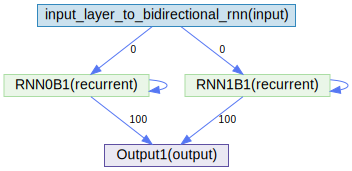

In [169]:
model.plot_network()

In [170]:
model.fit(data=data[data['_PartInd_']==0], 
          valid_table=data[data['_PartInd_']==1],
          inputs='des',
          texts='des',
          target='cat',
          nominals='cat',
          text_parms=TextParms(init_input_embeddings='emb', language='portuguese'),
          mini_batch_size=4, 
          max_epochs=100,
          lr=0.01,
          log_level=2)

NOTE: Training based on existing weights.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 122807.
NOTE:  The approximate memory cost is 17.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       7.86 (s).
NOTE:  The total number of threads on each worker is 10.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 40.
NOTE:  Target variable: CAT
NOTE:  Number of levels for the target variable:      7
NOTE:  Levels for the target variable:
NOTE:  Level      0: FERRAMENTAS   
NOTE:  Level      1: OBRAS DIVERSAS
NOTE:  Level      2: ÓLEOS        
NOTE:  Level      3: OUTROS        
NOTE:  Level      4: PAPÉIS       
NOTE:  Level      5: PLÁSTICOS    
NOTE:  Level      6: SABÕES       
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Lo

NOTE:  83         0.01          0.3294     0.1063            1.102           0.3143     4.69
NOTE:  84         0.01          0.3454     0.1067            1.165           0.3103     4.55
NOTE:  85         0.01          0.3296      0.103            1.067           0.3011     4.73
NOTE:  86         0.01          0.3282     0.1023             1.03           0.2915     4.67
NOTE:  87         0.01          0.3093    0.09743            1.078            0.299     4.60
NOTE:  88         0.01          0.3047    0.09765            1.021           0.2864     5.00
NOTE:  89         0.01          0.3081    0.09522            1.086           0.2938     4.96
NOTE:  90         0.01          0.3067    0.09522           0.9437           0.2739     4.54
NOTE:  91         0.01          0.3377    0.09832           0.9854           0.2808     4.67
NOTE:  92         0.01          0.2927    0.08835           0.9933           0.2792     4.78
NOTE:  93         0.01          0.2908    0.09057            1.036    

,Descr,Value
0,Model Name,bdlstm001
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,122000


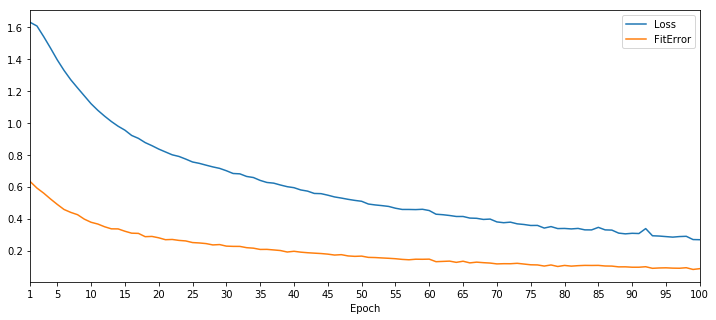

In [171]:
model.plot_training_history(tick_frequency=5)

In [172]:
model.predict(data[data['_PartInd_']==2],
              text_parms=TextParms(init_input_embeddings='emb', model_output_embeddings='bdsltm001'),
              use_best_weights=True)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4519
 1  Number of Observations Used          4519
 2  Misclassification Error (%)      26.06771
 3                   Loss Error      0.940753

[OutputCasTables]

              casLib              Name  Rows  Columns  \
 0  CASUSER(sasdemo)  Valid_Res_onRCA0  4519       15   
 
                                             casTable  
 0  CASTable('Valid_Res_onRCA0', caslib='CASUSER(s...  

+ Elapsed: 5.83s, user: 10.7s, sys: 2.62s, mem: 738mb

In [173]:
conf = sas.CASTable('Valid_Res_IcS0fu').crosstab(row='CAT', col='_DL_PredName_')
print(conf.Crosstab)

              CAT   Col1   Col2   Col3   Col4   Col5   Col6     Col7
0     FERRAMENTAS  109.0   34.0    4.0    3.0    4.0    5.0     61.0
1  OBRAS DIVERSAS   32.0  754.0    8.0    6.0    3.0    5.0    138.0
2          OUTROS   12.0   10.0  166.0    7.0    6.0    5.0     91.0
3          PAPÉIS    5.0   10.0   11.0  204.0    7.0   11.0     48.0
4       PLÁSTICOS    4.0    9.0    7.0    1.0  209.0    3.0     18.0
5          SABÕES    5.0    2.0    7.0    8.0    0.0  914.0    253.0
6           ÓLEOS   61.0   78.0   51.0    9.0    4.0   68.0  12924.0


# Train New Embeddings

In [ ]:
sas.loadactionset('textMining')
           documents="reviews", 
           entities="NONE",
           nounGroups=False,
           offset=dict(name='pos', replace=True),
           reduce=1,
           stemming=False,
           tagging=False,
           terms=dict(name='terms', replace=True),
           text="text"
        )

# Train New Model

# Save Models

# Terminate Session